## 1. Import required libraries

In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.0 MB/s eta 0:00:00


In [ ]:
import requests
import pdfplumber
import matplotlib.pyplot as plt
import ipywidgets as widgets
import getpass
import os
import re
import csv
from IPython.display import display
from openai import OpenAI

## 2. API setup



In [ ]:
if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key
global nvapi_key

NVAPI Key (starts with nvapi-): ··········


In [ ]:
client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = nvapi_key
)

## 3. Setup helper tools and functions

3.1 Open PDF files from resumes folder

In [ ]:
pdf_files = [f for f in os.listdir("/content/resumes") if f.endswith(".pdf")]
print(f"Found {len(pdf_files)} PDF Files in /content/resumes folder")

Found 2 PDF Files in /content/resumes folder


3.2 Define helper functions

In [ ]:
def extract_text_from_pdf(file):
  filepath = "/content/resumes/" + file
  with pdfplumber.open(filepath) as pdf:
      return "\n".join(page.extract_text() for page in pdf.pages if page.extract_text())



def get_text_inputs():
  company_name = input("Enter the company name: ") # "Visa"
  role_name = input("Enter the role name: ") # "Software Engineer"
  job_description = input("Enter the job description: ") # "This position is ideal for an engineer who is passionate about solving challenging business problems and building applications that provide an excellent user experience. They will be an integral part of the Payment Products Development team, focusing on the development of software solutions that leverage data to address business challenges. They will be extensively involved in hands-on activities including proof of concepts, development, and testing. They should demonstrate adaptability and readiness to change tasks according to the team's requirements.  Key Responsibilities  Developing and testing automation frameworks, and other related tasks, in addition to contributing to core product code.  Deliver high-quality products and features, taking a holistic view from the initial idea to final delivery. This involves design, development, testing, and accountability for release deployments as well as providing support post-deployment.  Understand the product in its entirety and ensure the timely delivery of your assigned module within an agile team setting.  Accurately scope efforts, identify risks, and clearly communicate trade-offs with team members and other stakeholders.  Coordinate and participate in Continuous Integration activities, Effectively communicate status updates, issues, and potential risks accurately and promptly.  Perform other tasks related to data governance and system infrastructure as required.   This is a hybrid position. Expectation of days in office will be confirmed by your hiring manager.  Qualifications  Basic Qualifications   Bachelors degree, OR 3+ years of relevant work experience  Preferred Qualifications   Bachelors degree, OR 3+ years of relevant work experience  Bachelor's degree in Computer Science or equivalent field  Relevant working experience of up to 2 years in the industry  Proven experience in software development in Test, particularly in data-centric projects, demonstrating adherence to standard development best practices  Strong understanding and practical experience with data structures and algorithms, with a passion for tackling complex problems  Proficiency in Java programming  Hands-on experience with Big Data technologies such as Hadoop, Spark, and Hive  Strong knowledge of Unix/Linux operating systems and Shell Scripting  Proficiency in working with RDBMS, SQL and In-memory DB such as Redis  Familiarity with version control systems, specifically Git  Experience working within an Agile framework  Experience with Kafka, Mock data service a good to have  Experience with Load Runner is highly advantageous e  Familiarity with AI concepts and tools, including GitHub Copilot for code development  Exposure to AI/ML development is an added advantage  Proficiency in working with In-memory Databases like Redis  Strong verbal and written communication skills, with a proactive and self-motivated approach to improving existing processes to enable faster iterations.   Demonstrated intellectual and analytical rigor, with a keen attention to detail  Team-oriented, energetic, and collaborative approach to work, coupled with a diplomatic and adaptable style"
  return company_name, role_name, job_description



def extract_name_and_summary(text):
    name_pattern = r"Candidate Name:\s*([^;]+);"  # Matches everything after "Candidate Name:" until ";"
    resume_summary_pattern = r"Resume Summary:\s*(.*)$"  # Matches everything after "Resume Summary:" until end

    name_match = re.search(name_pattern, text)
    resume_summary_match = re.search(resume_summary_pattern, text)

    name = name_match.group(1).strip() if name_match else None
    resume_summary = resume_summary_match.group(1).strip() if resume_summary_match else None

    return {
        "name": name,
        "resume_summary": resume_summary
    }



def extract_score_and_justification(text):
    score_pattern = r"Score:\s*(\d+);"  # Matches a number after "Score:" until ";"
    justification_pattern = r"Justification:\s*(.*)"  # Matches everything after "Justification:" until end

    score_match = re.search(score_pattern, text)
    justification_match = re.search(justification_pattern, text)

    score = int(score_match.group(1).strip()) if score_match else None
    justification = justification_match.group(1).strip() if justification_match else None

    return {
        "score": score,
        "justification": justification
    }



# Example usage (Uncomment for testing)
# sample_response_name = "Candidate Name: Jason Vega; Resume Summary: The candidate is a software engineer with 5 years of experience and a Bachelor's degree in Computer Science from Stanford University. The candidate is familiar with programming languages such as Java, C++, and Python. The resume provides a clear overview of the candidate's experience and qualifications."

# sample_response_score = "Score: 8; Justification: The resume is well-written and provides a clear overview of the candidate's experience and qualifications. The candidate has 5 years of experience as a software engineer and is familiar with programming languages such as Java, C++, and Python. The resume also mentions the candidate's Bachelor's degree in Computer Science from Stanford University. Overall, the resume is strong and demonstrates the candidate's qualifications for the role of Software Engineer at Google."

# print(extract_name_and_summary(sample_response_name))
# print(extract_score_and_justification(sample_response_score))


{'name': 'Jason Vega', 'resume_summary': "The candidate is a software engineer with 5 years of experience and a Bachelor's degree in Computer Science from Stanford University. The candidate is familiar with programming languages such as Java, C++, and Python. The resume provides a clear overview of the candidate's experience and qualifications."}
{'score': 8, 'justification': "The resume is well-written and provides a clear overview of the candidate's experience and qualifications. The candidate has 5 years of experience as a software engineer and is familiar with programming languages such as Java, C++, and Python. The resume also mentions the candidate's Bachelor's degree in Computer Science from Stanford University. Overall, the resume is strong and demonstrates the candidate's qualifications for the role of Software Engineer at Google."}


3.3 Define LLM API call

In [ ]:
# Samples used for prompt engineering

sample_prompt_name_summary = "Given the following resume, identify the name of the candidate and provide a summary of the resume.\n\nResume:\nI am Jason, a software engineer with 5 years of experience. I have worked on various projects to develop high-quality software. I am familiar with programming languages such as Java, C++, and Python. I have a Bachelor's degree in Computer Science from Stanford University. Use ';' to separate sections in your response."
sample_response_name_summary = "Candidate Name: Jason Vega; Resume Summary: The candidate is a software engineer with 5 years of experience and a Bachelor's degree in Computer Science from Stanford University. The candidate is familiar with programming languages such as Java, C++, and Python. The resume provides a clear overview of the candidate's experience and qualifications."

sample_prompt_score_justification = "Given the job description and resume below, please score the resume for the role of Software Engineer at Google.\n\nHere is a job description of the role that you can use to score the candidate. \nJob Description:\nWe are looking for a Software Engineer to join our team. You will work with our engineers to develop high-quality software. You will also work on various projects to improve our software. You should have experience in software development and be familiar with programming languages such as Java, C++, and Python.\n\nResume:\nI am Jason, a software engineer with 5 years of experience. I have worked on various projects to develop high-quality software. I am familiar with programming languages such as Java, C++, and Python. I have a Bachelor's degree in Computer Science from Stanford University. Use ';' to separate sections in your response."
sample_response_score_justification = "Score: 8; Justification: The resume is well-written and provides a clear overview of the candidate's experience and qualifications. The candidate has 5 years of experience as a software engineer and is familiar with programming languages such as Java, C++, and Python. The resume also mentions the candidate's Bachelor's degree in Computer Science from Stanford University. Overall, the resume is strong and demonstrates the candidate's qualifications for the role of Software Engineer at Google."

sample_prompt_two_name_summary = "Given the following resume, identify the name of the candidate and provide a summary of the resume.\n\nResume:\nI am George, a data analyst with 3 years of experience. I have worked on various projects to analyze data and provide insights. I am familiar with data analysis tools such as SQL and Python. I have a Bachelor's degree in Statistics from Harvard University. Use ';' to separate sections in your response."
sample_response_two_name_summary = "Candidate Name: George; Resume Summary: The candidate is a data analyst with 3 years of experience and a Bachelor's degree in Statistics from Harvard University. The candidate is familiar with data analysis tools such as SQL and Python. The resume provides a clear overview of the candidate's experience and qualifications."

sample_prompt_two_score_justification = "Given the job description and resume below, please score the resume for the role of Data Analyst at Facebook.\n\nHere is a job description of the role that you can use to score the candidate. \nJob Description:\nWe are looking for a Data Analyst to join our team. You will work with our data scientists to analyze data and provide insights. You will also work on various projects to improve our data analysis. You should have experience in data analysis and be familiar with data analysis tools such as SQL and Python.\n\nResume:\nI am George, a data analyst with 3 years of experience. I have worked on various projects to analyze data and provide insights. I am familiar with data analysis tools such as SQL and Python. I have a Bachelor's degree in Statistics from Harvard University. Use ';' to separate sections in your response."

sample_response_two_score_justification = "Score: 7; Justification: The resume is well-written and provides a clear overview of the candidate's experience and qualifications. The candidate has 3 years of experience as a data analyst and is familiar with data analysis tools such as SQL and Python. The resume also mentions the candidate's Bachelor's degree in Statistics from Harvard University. Overall, the resume is strong and demonstrates the candidate's qualifications for the role of Data Analyst at Facebook."

# Instructions used to define LLM's role
llm_instructions = "You are a hiring manager assessing candidates for their suitabilities for a specific role, based on the job description and the candidate resumes. You are to assign each of them a score within the range 1 to 10. Identify the name of the candidate from the resume. You are to provide a short justification for the score and a short summary of the resume."

In [ ]:
def get_name_summary(resume_text):
  prompt = "Given the following resume, identify the name of the candidate and provide a summary of the resume." + "\n\nResume:\n" + resume_text + "Use ';' to separate sections in your response, like in the earlier examples."

  completion = client.chat.completions.create(
    model="meta/llama-3.3-70b-instruct",
    messages=[
                { "role": "system", "content": llm_instructions },
                { "role": "user", "content": sample_prompt_name_summary },
                { "role": "assistant", "content": sample_response_name_summary },
                { "role": "user", "content": sample_prompt_two_name_summary },
                { "role": "assistant", "content": sample_response_two_name_summary },
                { "role": "user", "content": prompt }
              ],
    temperature=0.2,
    top_p=0.7,
    max_tokens=1024,
    stream=True
  )

  result = ""
  for chunk in completion:
    if chunk.choices[0].delta.content is not None:
      result += chunk.choices[0].delta.content

  return result

def get_score_justification(company_name, role_name, job_description, resume_text):
  prompt = "Given the job description and resume below, please score, on a scale of 1 - 10 where 10 is the best, and 1 is slightly suitable, the resume for the role of " + role_name + " at " + company_name + ".\n\nHere is a job description of the role that you can use to score the candidate and don't give high scores too easily. \nJob Description:\n" + job_description + "\n\nResume:\n" + resume_text + "Use ';' to separate sections in your response, like in the earlier examples."

  completion = client.chat.completions.create(
    model="meta/llama-3.3-70b-instruct",
    messages=[
                { "role": "system", "content": llm_instructions },
                { "role": "user", "content": sample_prompt_score_justification },
                { "role": "assistant", "content": sample_response_score_justification },
                { "role": "user", "content": sample_prompt_two_score_justification },
                { "role": "assistant", "content": sample_response_two_score_justification },
                { "role": "user", "content": prompt }
              ],
    temperature=0.2,
    top_p=0.7,
    max_tokens=1024,
    stream=True
  )

  result = ""
  for chunk in completion:
    if chunk.choices[0].delta.content is not None:
      result += chunk.choices[0].delta.content

  return result

## 4. Define main function

In [ ]:
def analyze_resume():
  print("Remember to upload your resumes to the resumes folder before continuing!")
  company_name, role_name, job_description = get_text_inputs()


  # Create CSV file if it doesn't exist
  csv_file_path = '/content/resumes_analysis.csv'
  if not os.path.exists(csv_file_path):
    with open(csv_file_path, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['File Name', 'Name', 'Score', 'Justification', 'Resume Summary'])


  print("\nAnalyzing resumes...\n")


  with open(csv_file_path, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)

    for file in pdf_files:
      resume_text = extract_text_from_pdf(file)

      # Make API calls
      llm_output_name = get_name_summary(resume_text)
      llm_output_score = get_score_justification(company_name, role_name, job_description, resume_text)


      # Extract values from API response
      name_summary = extract_name_and_summary(llm_output_name)
      score_justification = extract_score_and_justification(llm_output_score)

      name = name_summary['name']
      resume_summary = name_summary['resume_summary']
      score = score_justification['score']
      justification = score_justification['justification']


      # Write data to CSV
      writer.writerow([file, name, score, justification, resume_summary])

  print("\nAnalysis complete. Results saved to resume_analysis.csv")

## 5. Run it!

In [ ]:
analyze_resume()

Remember to upload your resumes to the resumes folder before continuing!

Analyzing resumes...




llm_output_nameCandidate Name: Lysandra Vega; Resume Summary: The candidate is a recent computer engineering graduate from Purdue University with a strong background in software engineering, seeking a role at Salesforce; she has experience as a software engineer intern at Infosys, where she utilized various skills such as Git, Python, and MySQL to improve code quality, app functionality, and database performance; she also led a group project, developing backup and recovery strategies, implementing efficient database schemas, and streamlining development time; the candidate possesses certifications such as Certified Software Development Professional (CSDP) and is proficient in a range of tools and technologies, including Visual Studio Code, Django, and Heroku.

llm_output_scoreScore: 6; Justification: The resume demonstrates some relevant skills and experience for the role of Software Engineer at Visa, such as proficiency in Python, Git, and MySQL, as well as experience with continuous


llm_output_nameCandidate Name: John Doe; Resume Summary: The candidate is a junior software engineer with 2 years of experience in full-stack development, proficient in programming languages such as Python, JavaScript, and React, with a strong foundation in software development principles and problem-solving, and a Bachelor of Science in Computer Science from the National University of Singapore, with experience in developing and maintaining web applications, collaborating with teams, and contributing to code quality and maintainability.

llm_output_scoreScore: 4; Justification: The candidate's resume shows some relevant experience and skills, but it lacks the specific qualifications and experience required for the role of Software Engineer at Visa. The candidate has experience in full-stack development, but the job description requires experience in software development, particularly in data-centric projects, and proficiency in Java programming, which is not mentioned in the resume. 

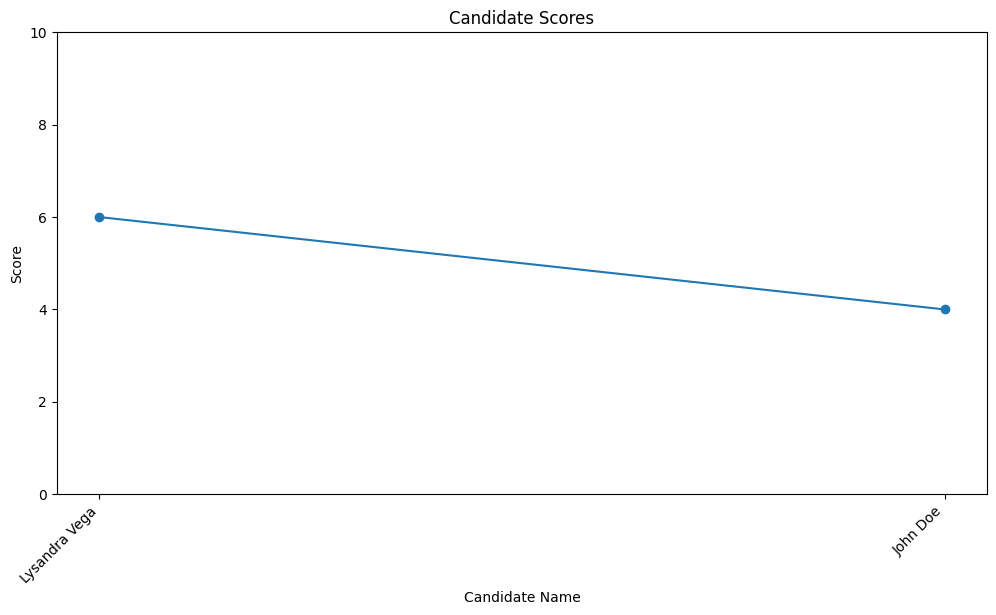

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV into a DataFrame
file_name = 'resumes_analysis.csv'  # Get the uploaded file name
df = pd.read_csv(file_name)

# Ensure the "Score" and "Name" column exists
if "Score" in df.columns and "Name" in df.columns:
    # Plot a line chart
    plt.figure(figsize=(12, 6))
    plt.plot(df["Name"], df["Score"], marker='o', linestyle='-')

    # Set axis labels and title
    plt.xlabel("Candidate Name")
    plt.ylabel("Score")
    plt.title("Candidate Scores")

    # Set y-axis limits
    plt.ylim(0, 10)

    # Rotate x-axis labels if there are many names
    plt.xticks(rotation=45, ha="right")

    # Show grid for better readability
    # plt.grid(True)

    # Show the plot
    plt.show()
else:
    print("Error: 'score' and/or 'name' column not found in the CSV file.")
